In [94]:
import pandas as pd
import numpy as np

import sidetable as stb

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from scipy.stats import kurtosistest
from scipy import stats

plt.rcParams['figure.figsize'] = (15, 10)
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

import holidays

In [95]:
df = pd.read_csv("data/bikes.csv", index_col= 0)
df.drop(["instant"], axis= 1, inplace= True)

OBJETIVO: analizar cuáles son los aspectos que más influyen en la cantidad de bicis que van a alquilar en un día.

VR: total_alquileres

In [96]:
df.shape

(730, 15)

In [97]:
df.stb.missing()

,missing,total,percent
dteday,0,730,0.0
season,0,730,0.0
yr,0,730,0.0
mnth,0,730,0.0
holiday,0,730,0.0
weekday,0,730,0.0
workingday,0,730,0.0
weathersit,0,730,0.0
temp,0,730,0.0
atemp,0,730,0.0


In [98]:
df.dtypes

dteday         object
season         object
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [99]:
df[df["season"] == "summer"]
df.sample()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
448,25-03-2019,summer,1,3,0,0,0,2,17.9375,21.8744,88.0833,14.791925,1532,3464,4996


# CAMBIO NOMBRE COLUMNAS:

In [100]:
diccionario = {
    "dteday": "fecha",
    "season": "estacion",
    "yr": "año",
    "mnth": "mes", 
    "holiday": "festivo", 
    "weekday": "dia_sem",
    "workingday": "laborable", 
    "weathersit": "prevision_tiempo",
    "temp": "temperatura",
    "atemp": "sensacion_termica", 
    "hum": "humedad", 
    "windspeed": "velocidad_viento", 
    "casual": "clientes_casual", 
    "registered": "clientes_registrados", 
    "cnt":"total_bicis"}

In [101]:
df.rename(columns = diccionario, inplace =True)
df.head()

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,temperatura,sensacion_termica,humedad,velocidad_viento,clientes_casual,clientes_registrados,total_bicis
0,01-01-2018,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,02-01-2018,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,03-01-2018,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,04-01-2018,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,05-01-2018,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# CAMBIO DATOS ESTACIÓN:

In [102]:
#Convertimos la columna fecha a formato datetime

df["fecha"] = df["fecha"].astype("datetime64", errors ="ignore")


In [103]:
#indicamos que el formato datetime sea el mismo que ya tiene la columna

df['fecha']= pd.to_datetime(df['fecha'], format = "%d-%m-%Y")

In [104]:
#Creamos la función para cambiar las estaciones del año

def cambio_estacion(fecha):
    inicio_primavera = datetime(fecha.year, 3, 20)
    fin_primavera = datetime(fecha.year, 6, 20)
    inicio_verano = datetime(fecha.year, 6, 21)
    fin_verano = datetime(fecha.year, 9, 22)
    inicio_otoño = datetime(fecha.year, 9, 23)
    fin_otoño = datetime(fecha.year, 12, 20)
    # Comprueba en qué estación del año cae la fecha dada
    if inicio_primavera <= fecha <= fin_primavera:
        return "Primavera"
    elif inicio_verano <= fecha <= fin_verano:
        return "Verano"
    elif inicio_otoño <= fecha <= fin_otoño:
        return "Otoño"
    else:
        return "Invierno"

In [105]:
df['estacion'] = df['fecha'].apply(cambio_estacion)

In [106]:
df['estacion'].unique()

array(['Invierno', 'Primavera', 'Verano', 'Otoño'], dtype=object)

In [107]:
df.sample(5)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,temperatura,sensacion_termica,humedad,velocidad_viento,clientes_casual,clientes_registrados,total_bicis
103,2018-04-14,Primavera,0,4,0,4,1,1,19.167500,23.13710,54.0417,7.416900,529,2738,3267
567,2019-07-22,Verano,1,7,0,0,0,2,27.367500,31.15625,76.2500,6.292694,2544,4866,7410
112,2018-04-23,Primavera,0,4,0,6,0,2,18.860000,22.50605,88.7917,15.458575,1462,2574,4036
45,2018-02-15,Invierno,0,2,0,2,1,1,10.909567,12.71370,31.4348,19.522058,140,1675,1815
12,2018-01-13,Invierno,0,1,0,4,1,1,6.765000,7.54415,47.0417,20.167000,38,1368,1406


In [108]:
#Comprobamos si total_bicis es la suma de clientes_casual y clientes_registrados

df['suma_clientes'] = df['clientes_casual'] + df['clientes_registrados']

In [109]:
df.sample(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,temperatura,sensacion_termica,humedad,velocidad_viento,clientes_casual,clientes_registrados,total_bicis,suma_clientes
73,2018-03-15,Invierno,0,3,0,2,1,2,13.013031,15.90890,65.5652,12.348703,289,1767,2056,2056
127,2018-05-08,Primavera,0,5,0,0,0,1,21.661653,25.94665,63.1667,5.000712,1401,2932,4333,4333


CONCLUSION

La columna total_bicis es la suma de las columnas clientes_casual + clientes_registrados, por tanto confirmamos en las columnas clientes_casual y clientes_registrados, si un cliente ha alquilado varias veces en un día, se contabiliza todas esas veces. 

In [110]:
#Eliminamos la columna de la suma, ya que no la vamos a necesitar más

df.drop(['suma_clientes'], axis = 1, inplace = True)

In [111]:
#Cambiamos los nombres de las columnas para que se entienda mejor
diccionario2 = {
    "clientes_casual": "alquiler_casual",
    "clientes_registrados": "alquiler_registrado",
    "total_bicis": "total_alquileres"}

df.rename(columns = diccionario2, inplace =True)
df.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,temperatura,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres
0,2018-01-01,Invierno,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2018-01-02,Invierno,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801


In [112]:
df.dtypes

fecha                  datetime64[ns]
estacion                       object
año                             int64
mes                             int64
festivo                         int64
dia_sem                         int64
laborable                       int64
prevision_tiempo                int64
temperatura                   float64
sensacion_termica             float64
humedad                       float64
velocidad_viento              float64
alquiler_casual                 int64
alquiler_registrado             int64
total_alquileres                int64
dtype: object

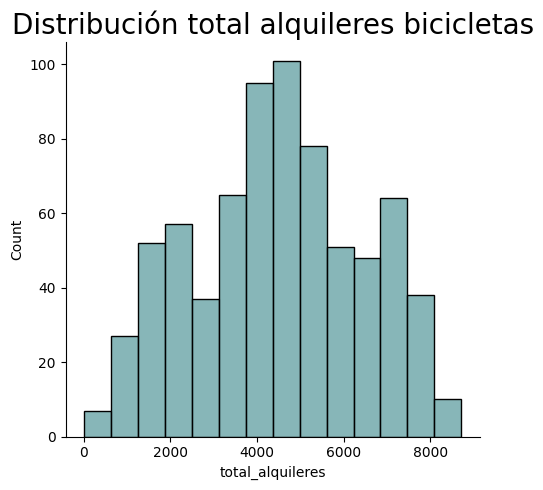

In [113]:
sns.displot(x ="total_alquileres", data = df,color = "cadetblue")
plt.title("Distribución total alquileres bicicletas", size = 20)
plt.tight_layout()
plt.xlabel=("")
plt.ylabel=("");

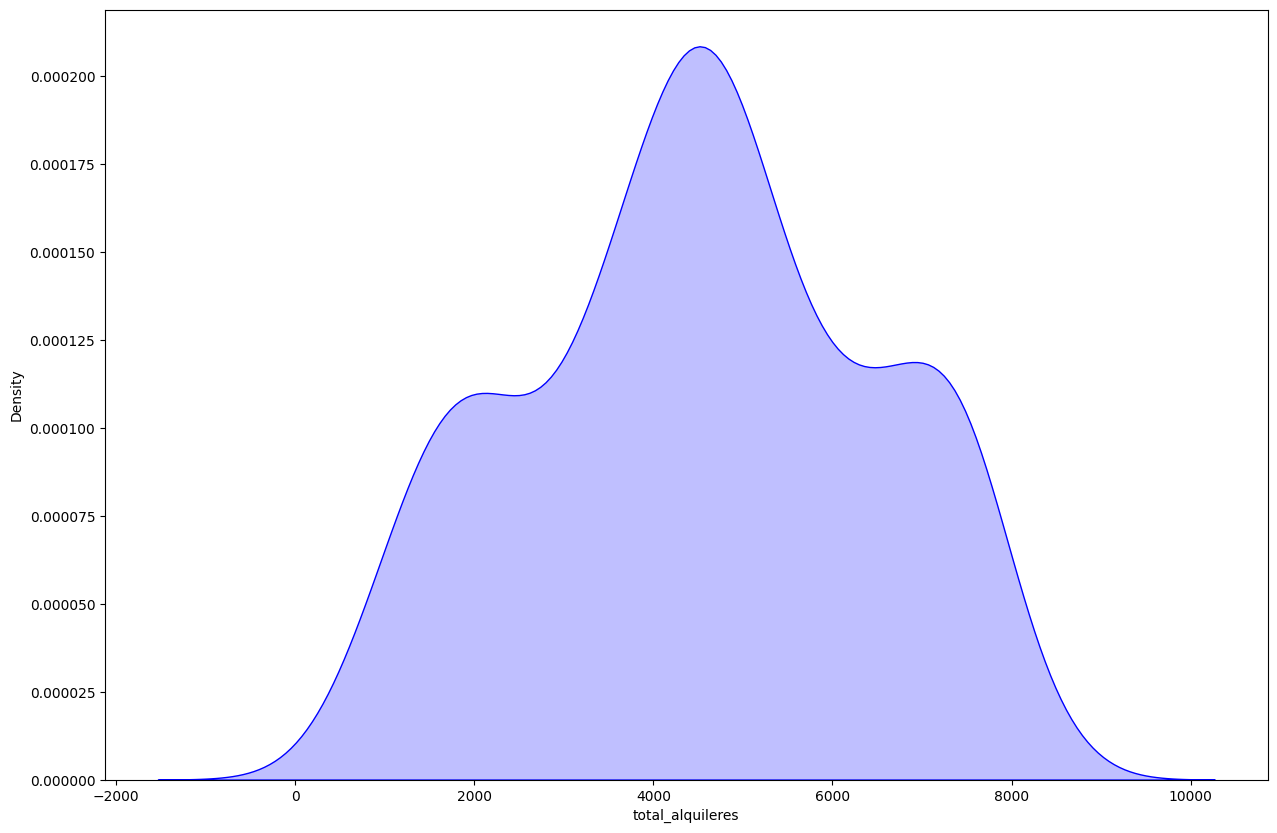

In [114]:
sns.distplot(
    df["total_alquileres"],
    hist = False,
    color = "blue",
    kde_kws = {"shade": True, "linewidth": 1});

CONCLUSIÓN: Los datos son simétricos aunque no forman una campana de Gauss perfecta.

In [115]:
df[['año', 'mes', 'festivo', 'dia_sem', 'laborable', 'prevision_tiempo']] = df[['año', 'mes', 'festivo', 'dia_sem', 'laborable', 'prevision_tiempo']].astype("category")

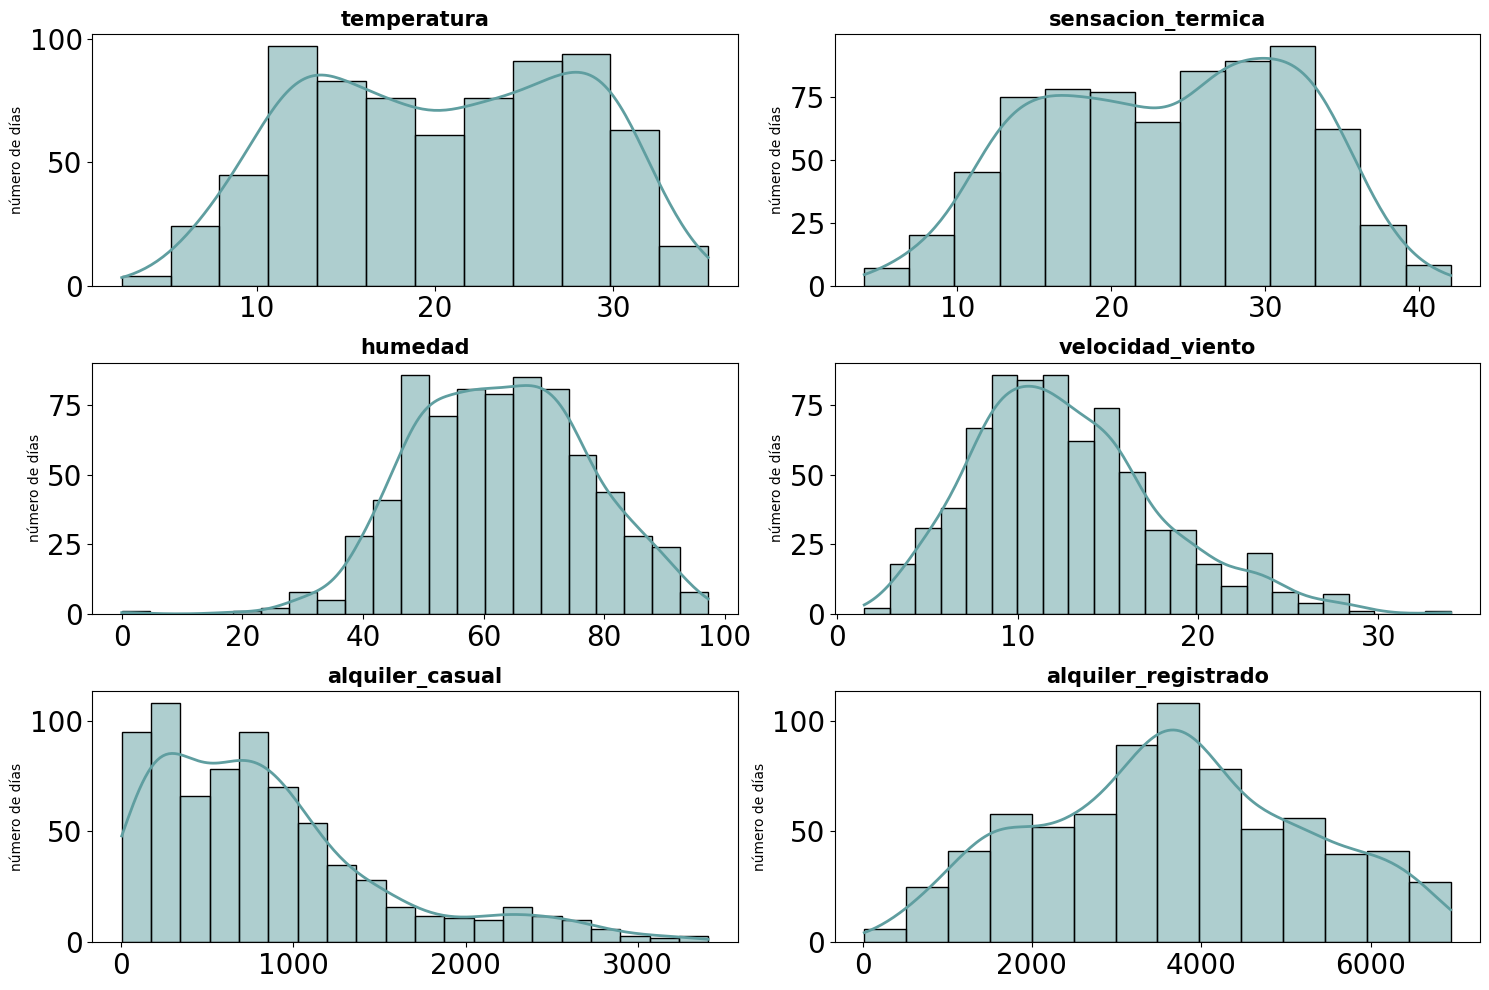

In [116]:
# Distribución de variables numéricas

df_num = df.select_dtypes(include= np.number)
num = df_num.drop("total_alquileres", axis = 1)

fig, axes = plt.subplots(nrows = 3, ncols = 2)
axes = axes.flat


for i, colum in enumerate(num.columns):
    sns.histplot(
        data = df,
        x = colum,
        kde = True,
        color = "cadetblue",
        line_kws = {"linewidth": 2},
        alpha = 0.5,
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("número de días")
    fig.tight_layout()


CONCLUSIONES:

- Aparentemente es un clima templado, sin temperaturas extremas. Gráfica simétrica.
- Lo mismo ocurre con la sensación térmica.
- En cuanto a la humedad, los datos parecen estar sesgados a la derecha; a pesar de haber humedades altas (> 60%) sigue habiendo un gran número de días húmedos y disminuye según la humedad se va acentuand.o. Clima relativamente húmedo.
- Hay menor número de días ventosos que no ventosos. Zona poco ventosa.
- En cuanto a los alquileres:
    - 

''

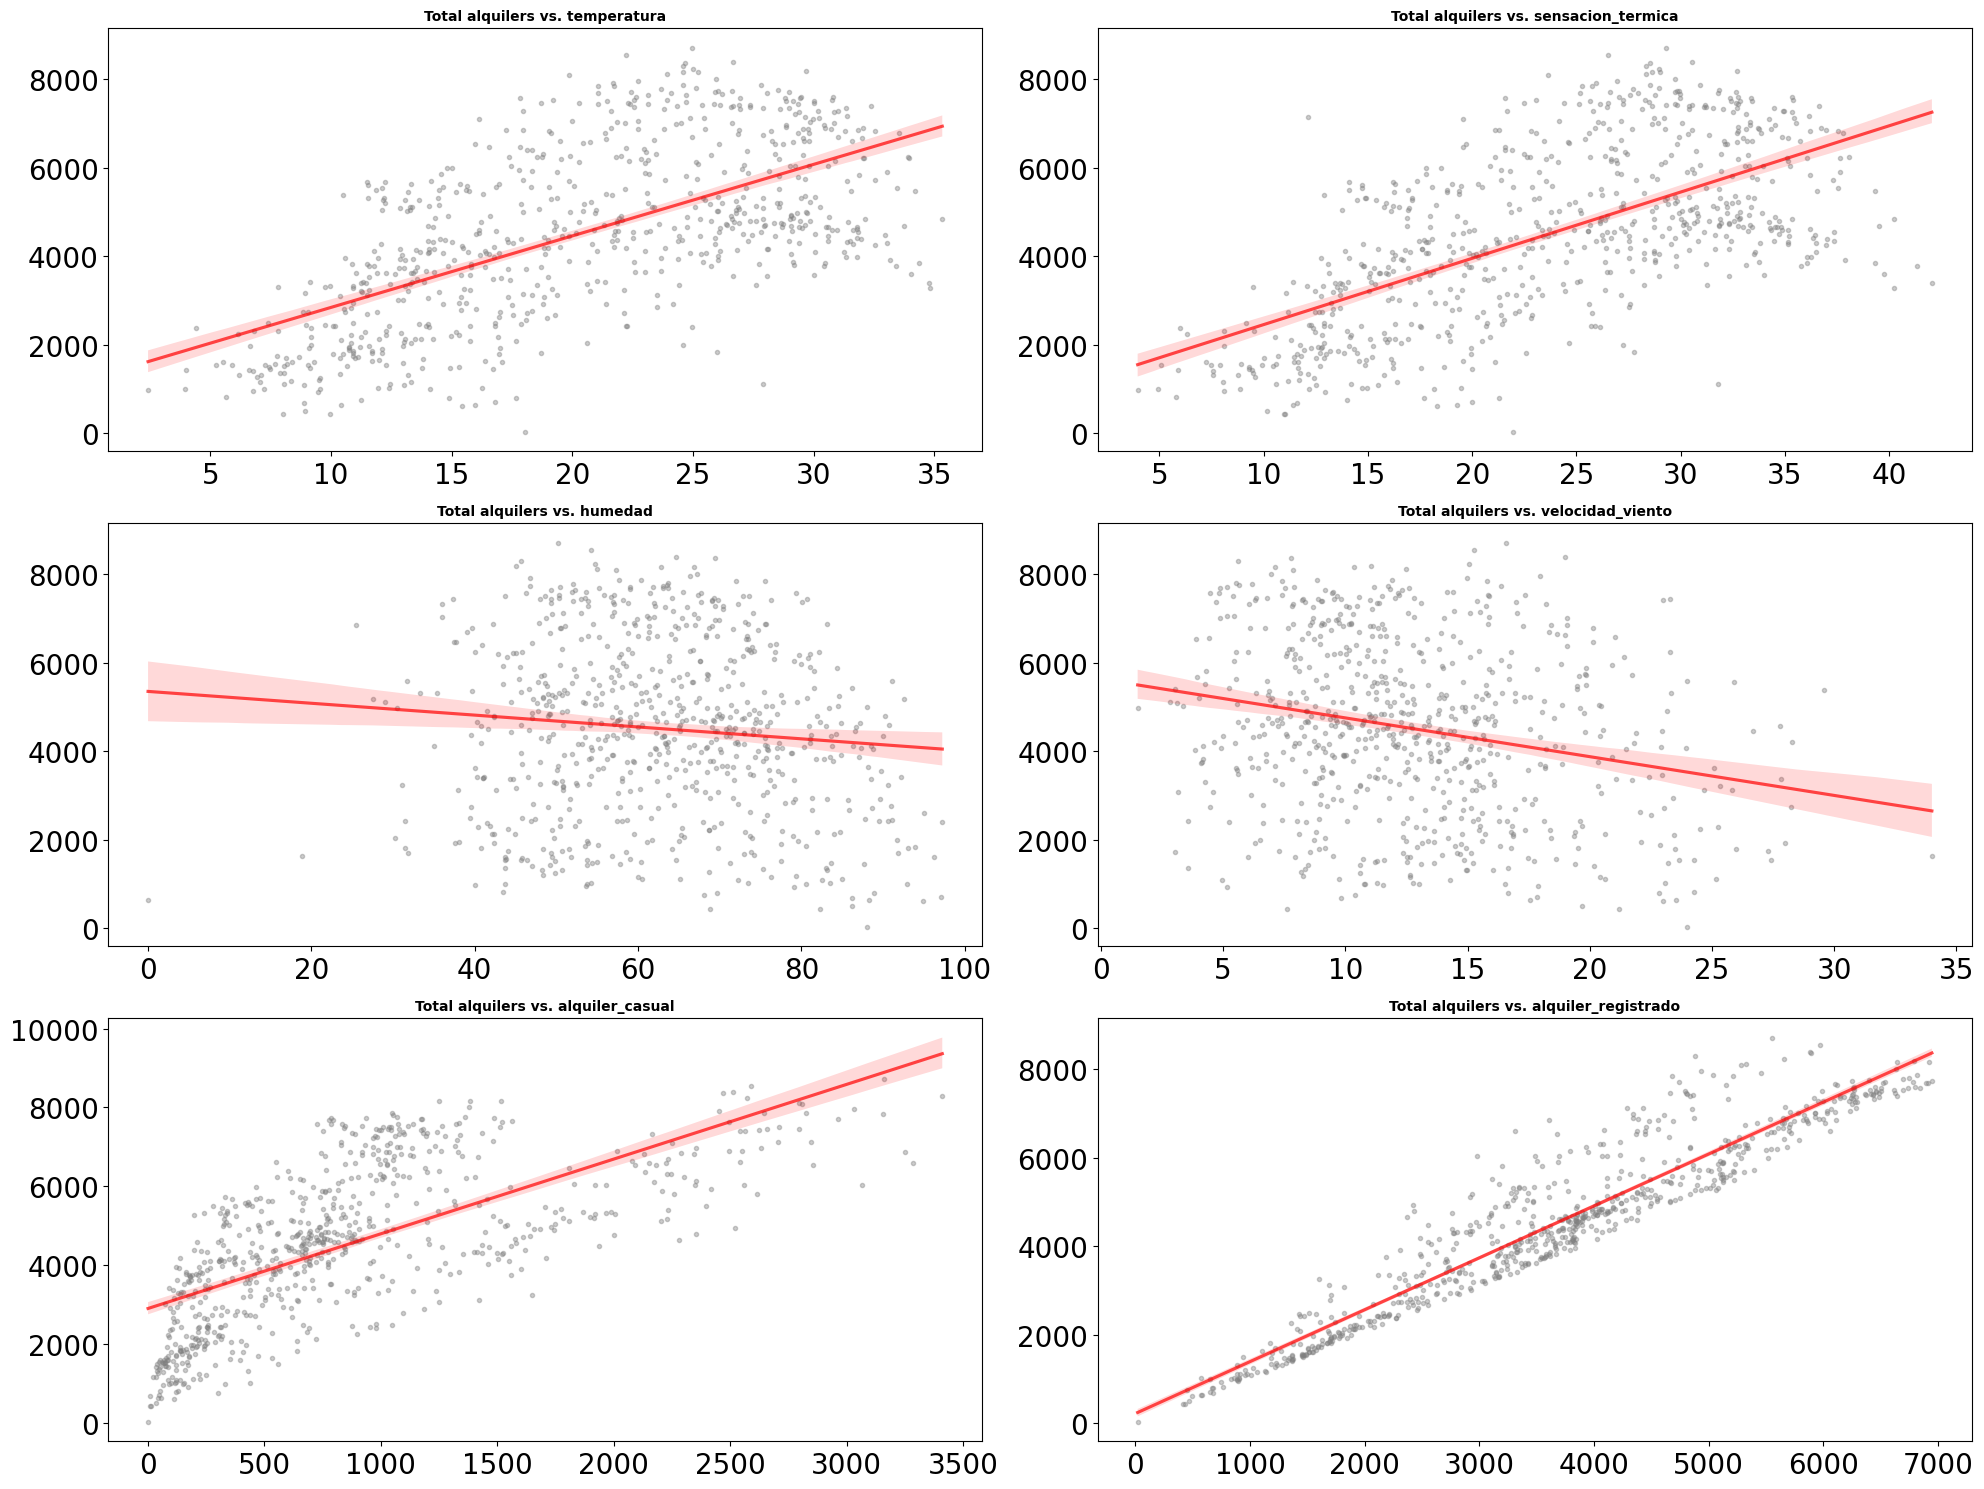

In [117]:
# Relación entre variables predictoras y la variable respuesta
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 15))
axes = axes.flat
num = df.select_dtypes(include = np.number).columns
num = num.drop("total_alquileres")
for i, colum in enumerate(num):
    sns.regplot(
        x = df[colum],
        y = df["total_alquileres"],
        color = "gray",
        marker = ".",
        scatter_kws = {"alpha": 0.4},
        line_kws = {"color": "red", "alpha": 0.7 },
        ax = axes[i])
    axes[i].set_title(f"Total alquilers vs. {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
fig.tight_layout()
;

En esta gráfica observamos que los clientes registrados en la empresa coinciden completamente con el total de alquiles, es decir, afectan positivamente en la variable respuesta. Por otro lado, vemos que la temperatura y la sensación térmica se parecen mucho y podríamos más adelante contemplar la posibilidad de quedarnos únicamente con una de las dos variables.
A continuación, miraremos la correlación entre las variables predictoras para ver cuánto están de relacionadas.


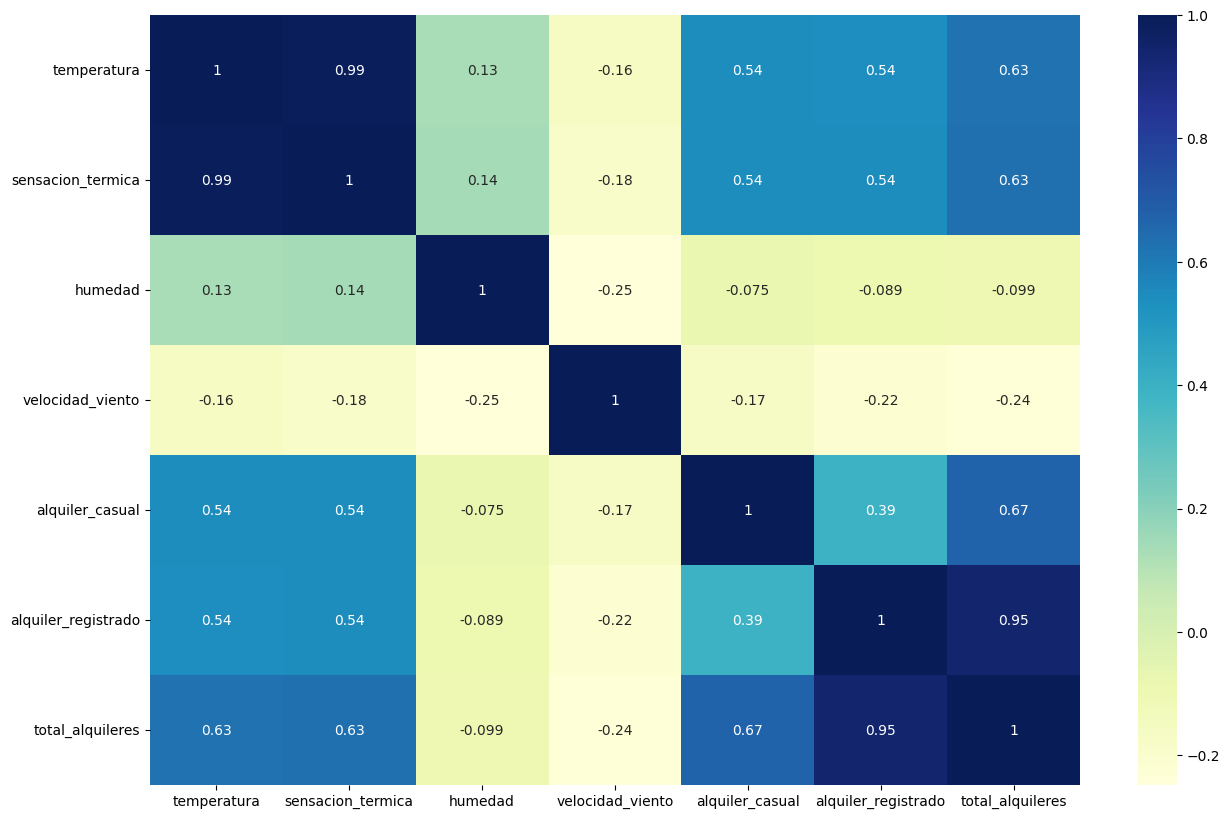

In [118]:
df_numericas = df.select_dtypes(include = np.number)
sns.heatmap(df_numericas.corr(numeric_only=True), 
           cmap = "YlGnBu", 
           annot = True);

Vemos que la correlación entre temperatura y sensación térmica es extremadamente alta. Por este motivo, ambas influyen de la misma manera a nuestra variable respuesta. Hemos elegido quedarnos con la variable sensación térmica porque al tratarse de un ejercicio físico, creemos que puede influir más en el cliente la sensación que tiene el cliente que la temperatura real que pueda haber.

In [119]:
df_cat = df.select_dtypes(exclude = np.number)
df_cat

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo
0,2018-01-01,Invierno,0,1,0,6,0,2
1,2018-01-02,Invierno,0,1,0,0,0,2
2,2018-01-03,Invierno,0,1,0,1,1,1
3,2018-01-04,Invierno,0,1,0,2,1,1
4,2018-01-05,Invierno,0,1,0,3,1,1
...,...,...,...,...,...,...,...,...
725,2019-12-27,Invierno,1,12,0,4,1,2
726,2019-12-28,Invierno,1,12,0,5,1,2
727,2019-12-29,Invierno,1,12,0,6,0,2
728,2019-12-30,Invierno,1,12,0,0,0,1


In [120]:
categoricas_lista = df_cat.drop(["fecha"], axis = 1).columns

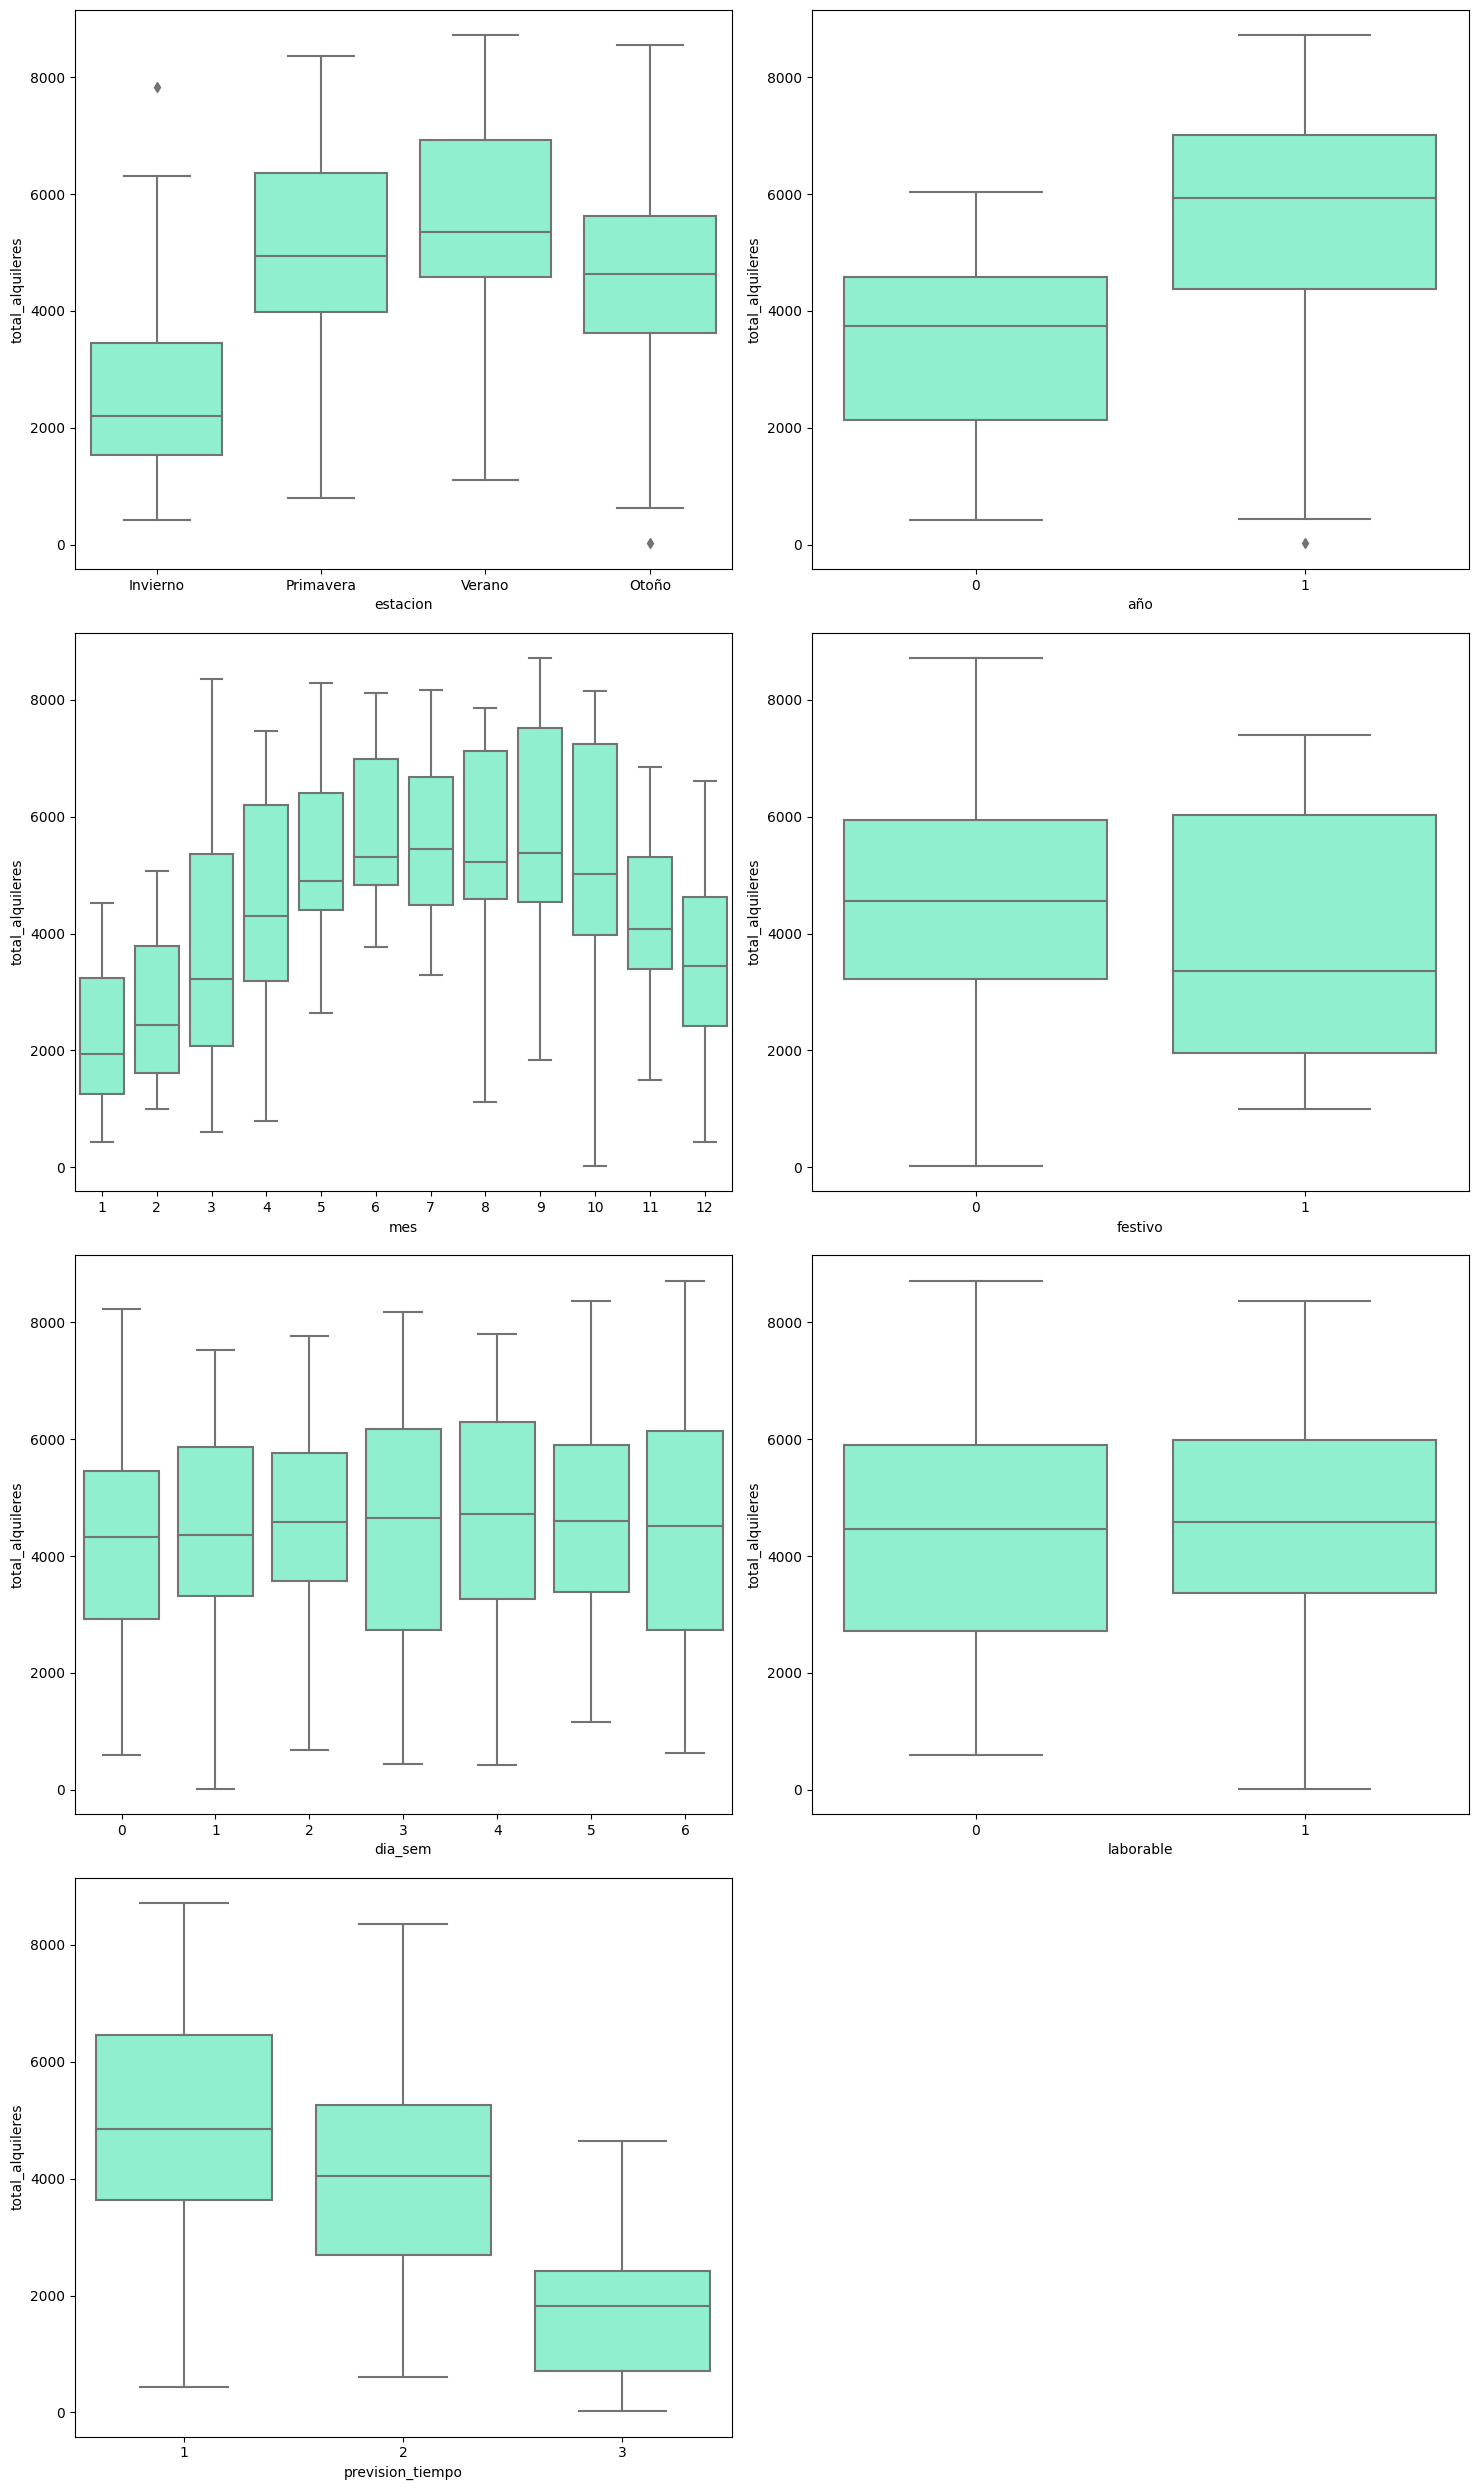

In [121]:
fig, axes = plt.subplots(4, 2, figsize=(15,25))

axes = axes.flat

for indice, columna in enumerate(categoricas_lista):
    sns.boxplot(x = df[columna], y = df["total_alquileres"], data = df, ax=axes[indice], color = "aquamarine");

    
plt.tight_layout()
fig.delaxes(axes[-1])
plt.show()

```Exploración de los valores de las variables categóricas y falsas numéricas```

In [122]:
df["estacion"].unique()

array(['Invierno', 'Primavera', 'Verano', 'Otoño'], dtype=object)

In [123]:
df["año"].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [124]:
df["mes"].unique()

[1, 2, 3, 4, 5, ..., 8, 9, 10, 11, 12]
Length: 12
Categories (12, int64): [1, 2, 3, 4, ..., 9, 10, 11, 12]

In [125]:
df["festivo"].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [126]:
df["dia_sem"].unique()

[6, 0, 1, 2, 3, 4, 5]
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]

In [127]:
df["laborable"].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [128]:
df["prevision_tiempo"].unique()

[2, 1, 3]
Categories (3, int64): [1, 2, 3]

In [129]:
!pip install holidays

```Cambio de valores de las variables falsas numéricas ```

In [130]:
dicc_año = {0:"2018", 1:"2019"}
df["año"] = df["año"].replace(dicc_año)

In [131]:
dicc_mes = {1:"enero", 2:"febrero", 3:"marzo", 4:"abril", 5:"mayo", 6:"junio", 7:"julio", 8:"agosto", 9:"septiembre", 10:"octubre", 11:"noviembre", 12:"diciembre"}
df["mes"] = df["mes"].replace(dicc_mes)

In [132]:
dicc_festivo = {0: "no_festivo", 1: "festivo"}
df["festivo"] = df["festivo"].replace(dicc_festivo)

In [133]:
df.sample(1)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,temperatura,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres
491,2019-05-07,Primavera,2019,mayo,no_festivo,1,1,2,22.0375,26.3571,66.4167,15.458307,1008,5265,6273


In [ ]:
dicc_2018 = {0: "martes", 1: "miercoles", 2:"jueves", 3:"viernes", 4:"sabado", 5:"domingo", 6:"lunes"}
dicc_2019 = {0: "lunes", 1: "martes", 2:"miercoles", 3:"jueves", 4:"viernes", 5:"sabado", 6:"domingo"}
   

new_val = df.index

for x in new_val:
    print(x)
        
       
    
    


In [ ]:
for k, v in dicc_2018:
    if df["año"] == 2018:
        df["festivo"] = df["festivo"]

In [ ]:
df.loc["2018", "año"] 

In [ ]:
for indice, fila, in df.iterrows():
    

In [ ]:
df.sample(1)

In [138]:
df["dia_sem"].weekday(1)

AttributeError: 'Series' object has no attribute 'weekday'